# train with pytorch


## down flower dataset

In [ ]:
!wget "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
!tar zxvf flower_photos.tgz

In [5]:
import gc
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, VisionDataset
from tqdm.auto import tqdm
import random
from pathlib import Path
import math
from pathlib import Path

In [6]:
myseed = 1234
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

## flower classify model

In [7]:
class flower_classify_model(nn.Module):
  def __init__(self):
    super(flower_classify_model, self).__init__()
    self.cnn = torchvision.models.efficientnet_b0(weights = "IMAGENET1K_V1")
    self.fc = nn.Linear(1000 , 5)
  def forward(self, img):

    out = self.cnn(img)
    out = self.fc(out)
    return out

## flower dataset

In [5]:
class flower_dataset(Dataset):
  def __init__(self,files,tfm):
    super(flower_dataset).__init__()

    self.files = files


    self.transform = tfm

  def __len__(self):
    return len(self.files)

  def __getitem__(self,idx):
    im = Image.open(self.files[idx][0])
    im = self.transform(im)
    return im , self.files[idx][1]



## data augmentation

In [6]:
image_size = (320,263)
test_tfm = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
])

train_tfm = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomAdjustSharpness(1.5, p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomAutocontrast(p=0.5),
    transforms.ColorJitter(0.2,0.2,0.2,0.05),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5,scale=(0.005,0.015),value=(1,1,1)),
])

## split train & valid set

In [7]:
def gen_train_vaild_files(flower_path , train_valid_ratio):

  train_files = []
  valid_files = []

  class_dic = {
    "daisy"  : 0,
    "dandelion" :  1,
    "roses" :  2,
    "sunflowers" : 3,
    "tulips" : 4
  }

  for class_folder in Path(flower_path).glob('*'):
    img_li = [i for i in class_folder.glob('*.jpg')]
    for idx , img_file in enumerate(img_li):
      if idx < len(img_li) * train_valid_ratio:
        train_files.append([img_file , class_dic[class_folder.stem]])
      else:
        valid_files.append([img_file , class_dic[class_folder.stem]])


  print(f"train set size : {len(train_files)}")
  print(f"valid set size : {len(valid_files)}")

  return train_files , valid_files

## hyperparameter

In [9]:
import torch
import torchvision


device = "cuda" if torch.cuda.is_available() else "cpu"
model = flower_classify_model().to(device)
batch_size = 32
n_epochs = 5
patience = 10
criterion = nn.CrossEntropyLoss(label_smoothing = 0.05)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)
_exp_name = "flower_classfication_model"
flower_path = "/content/flower_photos"
train_valid_ratio = 0.9


In [9]:
train_files , valid_files = gen_train_vaild_files(flower_path , train_valid_ratio)
train_set = flower_dataset(train_files , tfm=train_tfm)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_set = flower_dataset(valid_files, tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

train set size : 3306
valid set size : 364


## training

In [10]:
stale = 0
best_acc = 0
train_acc_record = []
train_loss_record = []
valid_acc_record = []
valid_loss_record = []

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []
    for batch in tqdm(train_loader):

        imgs , labels = batch

        logits = model(imgs.to(device))


        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    train_acc_record.append(train_acc.to('cpu'))
    train_loss_record.append(train_loss)
    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        #break

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    valid_acc_record.append(valid_acc.to('cpu'))
    valid_loss_record.append(valid_loss)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

    # update logs
    if valid_acc > best_acc:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
    else:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # save models
    if valid_acc > best_acc:
        print(f"Best model found at epoch {epoch}, saving model")
        torch.save(model.state_dict(), f"{_exp_name}_best.pt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break

  0%|          | 0/104 [00:00<?, ?it/s]

[ Train | 001/005 ] loss = 0.58016, acc = 0.85685


  0%|          | 0/12 [00:00<?, ?it/s]

[ Valid | 001/005 ] loss = 0.36087, acc = 0.95920
[ Valid | 001/005 ] loss = 0.36087, acc = 0.95920 -> best
Best model found at epoch 0, saving model


  0%|          | 0/104 [00:00<?, ?it/s]

[ Train | 002/005 ] loss = 0.37553, acc = 0.94916


  0%|          | 0/12 [00:00<?, ?it/s]

[ Valid | 002/005 ] loss = 0.33944, acc = 0.95920
[ Valid | 002/005 ] loss = 0.33944, acc = 0.95920


  0%|          | 0/104 [00:00<?, ?it/s]

[ Train | 003/005 ] loss = 0.32576, acc = 0.96815


  0%|          | 0/12 [00:00<?, ?it/s]

[ Valid | 003/005 ] loss = 0.33419, acc = 0.96615
[ Valid | 003/005 ] loss = 0.33419, acc = 0.96615 -> best
Best model found at epoch 2, saving model


  0%|          | 0/104 [00:00<?, ?it/s]

[ Train | 004/005 ] loss = 0.29572, acc = 0.98377


  0%|          | 0/12 [00:00<?, ?it/s]

[ Valid | 004/005 ] loss = 0.34907, acc = 0.95573
[ Valid | 004/005 ] loss = 0.34907, acc = 0.95573


  0%|          | 0/104 [00:00<?, ?it/s]

[ Train | 005/005 ] loss = 0.27866, acc = 0.98678


  0%|          | 0/12 [00:00<?, ?it/s]

[ Valid | 005/005 ] loss = 0.33699, acc = 0.95052
[ Valid | 005/005 ] loss = 0.33699, acc = 0.95052


## train log

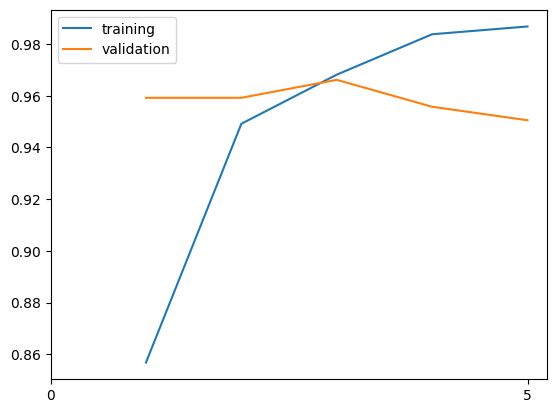

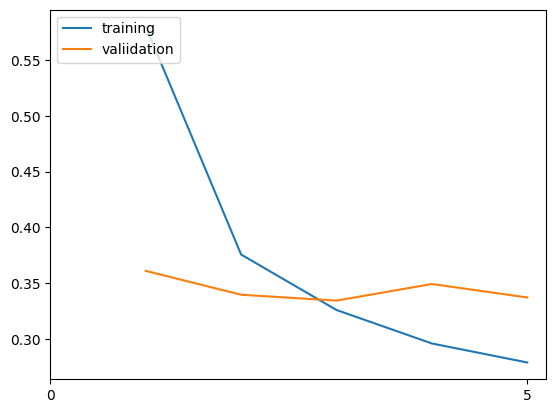

In [11]:
import matplotlib.pyplot as plt

plt.plot([*range(1,len(train_acc_record)+1)] , train_acc_record , label = "training")
plt.plot([*range(1,len(train_acc_record)+1)] , valid_acc_record , label = "validation")

plt.xticks(np.arange(0, n_epochs+1, 5))
plt.legend(loc="upper left")

plt.savefig('acc.png')
plt.show()


plt.plot([*range(1,len(train_acc_record)+1)] , train_loss_record , label = "training")
plt.plot([*range(1,len(train_acc_record)+1)] , valid_loss_record , label = "valiidation")

plt.xticks(np.arange(0, n_epochs+1, 5))
plt.legend(loc="upper left")

plt.savefig('loss.png')
plt.show()

# .pt model to .onnx

In [12]:
!pip install onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 58.1 MB/s eta 0:00:00


In [13]:
model = flower_classify_model()
model.load_state_dict(torch.load(f"{_exp_name}_best.pt"))
model.eval()

# Input to the model
batch_size = 1
x = torch.randn(batch_size, 3, 320 , 263, requires_grad=True)
torch_out = model(x)
# Export the model
torch.onnx.export(model,# model being run
        x,   # model input (or a tuple for multiple inputs)
        f"{_exp_name}_best.onnx",  # where to save the model (can be a file or file-like object)
        export_params=True, # store the trained parameter weights inside the model file
        opset_version=10,   # the ONNX version to export the model to
        do_constant_folding=True, # whether to execute constant folding for optimization
        input_names = ['input'],  # the model's input names
        output_names = ['output'], # the model's output names
        dynamic_axes={'input' : {0 : 'batch_size'}, # variable length axes
            'output' : {0 : 'batch_size'}})

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

